# Filtering

In this notebook, we review fitting methods that can be applied to the particles we reviewed in the `Particles.ipynb` notebook.

The core idea of Particle Filtering is that we simulate a system many times, and that we preferentially over-sample simulations which closely resemble our observed data.  First, we simulate the system many times; then, we collect simulated observational data (e.g. hospital admissions).  This data can then be compared to our real observed data and assigned a score.  Then, in a traditional particle filter, we resample the particles with replacement and with probability weights determined by the evaluation criteria.  Typically, particle filtering algorithms will only resample the data when a certain threshold is reached.  This threshold is based on the _diversity_ of particle weights - if the weights between particles have  diverged significantly, this triggers a filtering step.  Otherwise, the algorithm waits because the filtering is unlikely to accomplish anything (non-diverse weights mean that the filtering is essentially just a random shuffle, as opposed to a targeted resampling of high-quality simulations).

### Implementation

We have designed our implementation of the particle filter (or Genetic Particle Filter) to be extremely simple.  We need only one function - `particle_filter` - to fit our model.

We begin by importing this function.

In [2]:
from covid_particle_filter.filter.filter import particle_filter

The `particle_filter` function takes 6 arguments:

    h_obs (list): a list of tuples (t,y) that indicates the evaluation value (y) occurring between the 
         previous pair's t value and the current t value (by default, hospital admissions over that period)
    n_particles (int): the number of particles to create (default 10000)
    dt (numeric): the step size for the simulation (NOT for the evaluation steps; default 0.1)
    gen (generator): a generator to construct a set of particles (default SEIHR_generator from the particle module)
    particles (list of instantiated Particle objects): a list of particles that have already been partially fitted 
        (overrides the generator and continues fitting these particles)
    s_min (float): minimum effective sample size that triggers resampling (defaults to 0.9*n_particles if None/not specified)
    
Our first argument, `h_obs`, determines the fitting period.  You must include a list of tuple with timestamps (in the 'time-since initiation' sense) and observed quantities to fit against (typically, the hospital admissions observed since the previous timsestamp).  Note that this argument will determine how long a set of particles fits for.  Particles cannot be fit without the appropriate data and all data submitted to the model is used.

The remaining arguments are hyperparameters used in the fitting process.  The `n_particles` hyperparameter tells the model how many simulations (particles) to use.  `dt` determines the simulation timestep, as reviewed in the `Particle.ipynb` notebook.  You must also provide _either_ a particle generator (`gen`) or a list of pre-generated particles (`particles`); the latter option can be used to continue fitting for a partially-fit set of particles that you would like to update with the latest data.  Finally, you can select `s_min`, the minimum  effective sample size in order to trigger a resampling step.  `S` is our measure of particle diversity, as described by [Murphy](http://noiselab.ucsd.edu/ECE228/Murphy_Machine_Learning.pdf).

We present the code below (this is a full copy, less some comments, of the filter code available in epicomp/covid_particle_filter/filter/filter.py).

In [ ]:
from covid_particle_filter.particle.SEIHR import SEIHR_generator
import numpy as np
import warnings

def particle_filter(
    h_obs,
    n_particles = 10000,
    dt = 0.1,
    gen = SEIHR_generator(100000),
    particles = None,
    s_min = None
):
    
    # Get the list of particles to fit
    if particles is not None:
        n_particles = len(particles)
        t_prev = particles[0].t
        if any([t_ <= t_prev for t_, y in h_obs]):
            warnings.warn("Dropping observations with time below current simulation time")
            h_obs = [(t_, y) for t_, y in h_obs if t_ > t_prev]
            
        particles = [p.copy() for p in particles]
        
    else:
        particles = [
            gen.generate(i) for i in range(n_particles)
        ]
        t_prev = 0
    
    if s_min is None:
        s_min = n_particles*0.9
    
    #Loop over observations
    for t, y in h_obs:
        
        #Using list comprehension; for each particle, step forward to the next evaluation point
        #and update weights based on the eval_value, which need not be atomic
        tmp_particles = [
            x.step(t, i, dt = dt, eval_value = y) for x, i in zip(particles, range(len(particles)))
        ]
        
        #Harvest the weights from all particles, then normalize to add to 1
        pre_weights = [x.w_t for x in tmp_particles]
        weights = np.array(pre_weights)/np.sum(pre_weights)
        s_eff = 1/np.sum(weights**2)
        
        for x, w in zip(tmp_particles, weights):
            x.w_t = w
            
        print(s_eff)
        
        #If effective sample size is below minimum, then perform resampling
        if s_eff < s_min:
            
            particles = np.random.choice(
                tmp_particles,
                p = weights, 
                replace = 1, 
                size = len(particles)
            )
            
            for x in particles:
                x.w_t = 1/len(particles)
                
        else:
            particles = tmp_particles
        
    return particles

#### Example

To illustrate how easy this function is to use, let's try to fit some simulated data.  First, we specify a particle to simulate hospital admissions with a known set of parameter values.

In [79]:
from covid_particle_filter.particle.SEIHR import SEIHR_generator
import numpy as np
import pandas as pd

canon_SEIHR_param_prior = {
    'beta'  : [(0.8, None)],
    'alpha' : [(0.2, None)],
    'gamma' : [(0.25, None)],
    'h_rate' : [(0.03, None)]
}

canon_SEIHR_init_prior = {
    'S'   : 98,
    'E'   : 1,
    'I'   : 1,
    'H'  : 0,
    'R'   : 0,
}

canonical_particle = SEIHR_generator(
    500000,
    param_prior_dict = canon_SEIHR_param_prior,
    init_prior_dict = canon_SEIHR_init_prior
).generate(0)

canonical_particle_sim = canonical_particle.step(30,0,0.1)

In [80]:
canonical_particle_sim.history

array([[490000,   5000,   5000,      0,      0],
       [486129,   7620,   4976,     41,   1234],
       [482199,   9896,   5296,     80,   2529],
       [477944,  11981,   6060,    124,   3891],
       [472934,  14375,   7113,    172,   5406],
       [467202,  17062,   8198,    237,   7301],
       [460798,  19807,   9634,    318,   9443],
       [453167,  23263,  11209,    391,  11970],
       [444592,  26882,  13143,    479,  14904],
       [434512,  31113,  15482,    572,  18321],
       [423072,  35962,  17909,    689,  22368],
       [410162,  41175,  20865,    836,  26962],
       [396002,  46679,  23916,    986,  32417],
       [380188,  52547,  27480,   1169,  38616],
       [362811,  58990,  31011,   1391,  45797],
       [344299,  65155,  35121,   1668,  53757],
       [324506,  71539,  39247,   1922,  62786],
       [303761,  77367,  43706,   2230,  72936],
       [282222,  82829,  48281,   2561,  84107],
       [260204,  87902,  52705,   2907,  96282],
       [238402,  918

In [81]:
h_obs = canonical_particle_sim.history[1:,-2] - canonical_particle_sim.history[:-1,-2]

In [82]:
h_obs

array([ 41,  39,  44,  48,  65,  81,  73,  88,  93, 117, 147, 150, 183,
       222, 277, 254, 308, 331, 346, 397, 452, 481, 513, 561, 537, 499,
       569, 572, 512, 524])

`h_obs` gives us our daily hospital admissions, which is going to be used as our fitting data.  Now, let's create some prior distributions.  We won't center our priors on our true values, but we do need to make sure that those values are included in the possible values.

When we fit our particles, notice that we get a diagnostic printout.  This printout indicates our filter's effective sample size (S) at each fitting step (day).  

In [88]:
fit_SEIHR_param_prior = {
    'beta'  : [(lambda : np.random.normal(1, .15), None)],
    'alpha' : [(lambda : np.random.gamma(0.5,0.2), None)],
    'gamma' : [(lambda : np.random.gamma(0.5,0.2), None)],
    'h_rate' : [(lambda : np.random.lognormal(-3,0.4), None)]
}

fit_SEIHR_init_prior = {
    'S'   : 98,
    'E'   : np.random.lognormal(0.75,0.5),
    'I'   : np.random.lognormal(0.75,0.5),
    'H'  : 0,
    'R'   : 0
}

fit_generator = SEIHR_generator(
    500000,
    param_prior_dict = fit_SEIHR_param_prior,
    init_prior_dict = fit_SEIHR_init_prior
)

In [89]:
from covid_particle_filter.filter.filter import particle_filter

In [90]:
from covid_particle_filter.filter.filter import particle_filter

filtered_particles = particle_filter(
    h_obs = [(i+1,h_obs[i]) for i in range(len(h_obs))],
    n_particles = 20000,
    dt = 0.1,
    gen = fit_generator,
    s_min = 20000*0.6
)

2534.094720606521
12983.247726041438
7168.172194748608
13278.328914938484
6805.876296683805
12003.960120464093
11066.308114600486
16700.36874327179
10383.263844464891
18107.66387853993
12056.146996506313
11298.87113119153
17780.82080633688
11905.500053690692
5832.532897564613
13058.14932691773
13024.093032643334
10672.163030306298
13767.459288733777
12517.6892711139
12189.900137345738
11152.341886308912
19158.439227162027
15650.3543211226
13081.913071380908
6888.806455777029
13692.12803910475
10194.410871744643
6724.80843548626
11434.064834151794


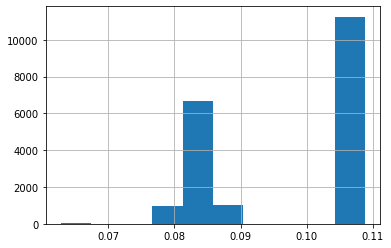

In [91]:
pd.Series([x.param_generator.params['alpha']['cur'] for x in filtered_particles]).hist()

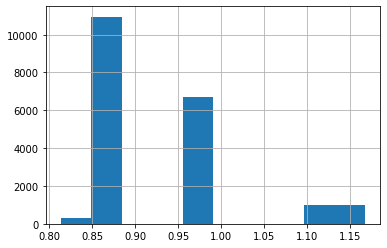

In [92]:
pd.Series([x.param_generator.params['beta']['cur'] for x in filtered_particles]).hist()

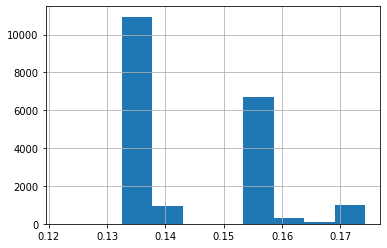

In [93]:
pd.Series([x.param_generator.params['gamma']['cur'] for x in filtered_particles]).hist()

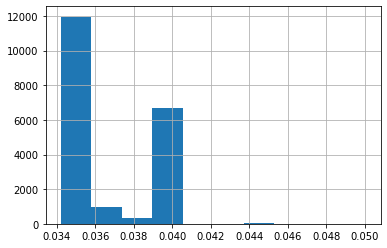

In [94]:
pd.Series([x.param_generator.params['h_rate']['cur'] for x in filtered_particles]).hist()

While the results from this fit look reasonable, there's a lot of room for optimization.  Note that we have many, many particles with identical parameter values.  This is called 'particle depletion', and it occurs because a small number of particles grew to dominate the simulation space.  This can produce ineffective samples and force us to use multiple chains, more particles, or to re-specify our model several times with better prior distributions.  All  of these are good ideas, but the algorithm is highly likely to collapse in this fashion over time.

One way to deal with this is to allow particle parameters to correct themselves instead of eliminating them.  This can increase our particle diversity and help particles converge better.  We do this using a genetic algorithm to adjust 'bad' particles to look more like 'good' particles, instead of just dropping the bad ones.  Our implementation is very similar to that detailed  by [Li et al.](https://pubmed.ncbi.nlm.nih.gov/28350341/).

Note that the entire interface to this algorithm is identical; we just need to import from `filter_ga` instead of `filter`.

In [95]:
from covid_particle_filter.filter.filter_ga import particle_filter

In [96]:
filtered_particles_ga = particle_filter(
    h_obs = [(i+1,h_obs[i]) for i in range(len(h_obs))],
    n_particles = 20000,
    dt = 0.1,
    gen = fit_generator,
    s_min = 20000*0.6
)

2572.342311258843
13145.31905383956
7218.245861065331
12714.356071714596
5597.441850504216
11524.766744288901
9657.627824754136
16261.752262727374
8735.529738935042
18400.050132636425
14339.561633939093
12964.452950610847
10537.282201982307
13577.780251516326
3371.306696033133
13525.668928435298
13020.346390498986
10640.304171734238
12308.16219551351
10252.493483548551
18245.99665174157
16575.886608032157
14722.151842266418
11100.786610089703
12539.864895290853
4646.331326511919
17258.99366754389
10954.015639752482
6334.279262368668
3626.7262564522516


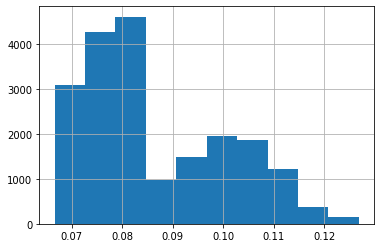

In [97]:
pd.Series([x.param_generator.params['alpha']['cur'] for x in filtered_particles_ga]).hist()

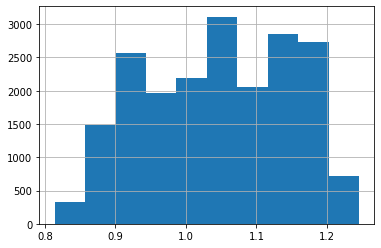

In [98]:
pd.Series([x.param_generator.params['beta']['cur'] for x in filtered_particles_ga]).hist()

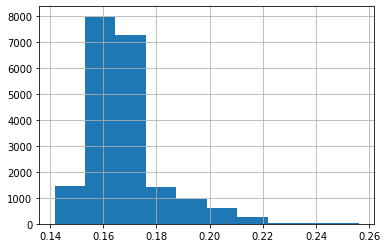

In [99]:
pd.Series([x.param_generator.params['gamma']['cur'] for x in filtered_particles_ga]).hist()

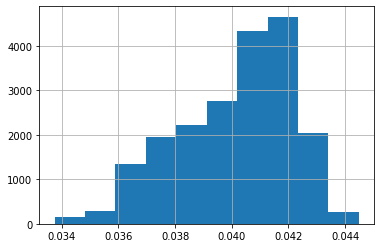

In [100]:
pd.Series([x.param_generator.params['h_rate']['cur'] for x in filtered_particles_ga]).hist()

Once again, we find that this particle filter is imperfect.  Likely, we'd need to re-specify our prior distributions, increase the number of particles used, and possibly fit on more data; however, it is also apparent that these simulations offer significantly more robust posterior samples for our parameters.

To illustrate how we can use these forecasts, let's also examine what happens when we simulate both our fitted particles and our simulation forward for another 10 days.

In [101]:
sim_fut = canonical_particle_sim.step(40, 0, 0.1)

In [102]:
forecast_parts = [x.step(40,0,0.1) for x in filtered_particles_ga]

In [116]:
h_obs_fut = sim_fut.history[-1,-2] - sim_fut.history[-10,-2]

In [119]:
lb, med, ub = np.percentile(np.array([
    x.history[-1,-2] - x.history[-10,-2] for x in forecast_parts
]), [2.5,50,97.5])

In [120]:
print('simulated actual: '  + str(h_obs_fut))
print('simulated CI: '  + str([lb, med, ub]))

simulated actual: 3278
simulated CI: [4093.0, 4539.0, 4799.0]


It is also possible to use a Combined version of the particle to simulate instantaneous hospital census over time, as we demonstrated in the `Particle.ipynb` notebook.

# Conclusion

In this notebook, we have demonstrated how to use both versions of the `particle` function and how to easily use the fitted particles to generate forecasts.  We leave it to the user to find effective prior distributions to fit their own data, as this can be a complex task that is best performed on a case-by-case basis.